In [13]:
### Initialize & Read in data ###

from pylab import *
import numpy as np
import scipy as sp
import time
import os
import multiprocessing

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.collections import LineCollection
%matplotlib inline
# Normal matplotlib => just wrap in $ for latex

import mpld3 # This is a widget for zooming in and manipulating plots
mpld3.enable_notebook()

from sklearn import gaussian_process

In [14]:
### 27912 tracks numbers, 27891 total tracks ###
### Cut matrix: 300 track numbers 292 total tracks ###
### Create data matrix ###

dir_path = '/Users/michaelzevin/Documents/Stellar Evolution/Data/npy_resampled_cut/'

### Read in the inputs & outputs for each track ###
inputs = []
outputs_1 = []
outputs_2 = []

for file in os.listdir(dir_path):
    x = np.load(dir_path + file)
    
    inputs.append([[float(x['Mbh_init'])],[float(x['M2_init'])],[float(x['P_init'])]])
        
    outputs_1.append(x['xr1'])
    outputs_2.append(x['xr2'])
                
inputs = np.reshape(inputs,[len(inputs),3])   # Format: [Run,IC]

The initial conditions for track 150 are: Mbh = 3.000000, M2 = 0.992905, & P = 5.087865


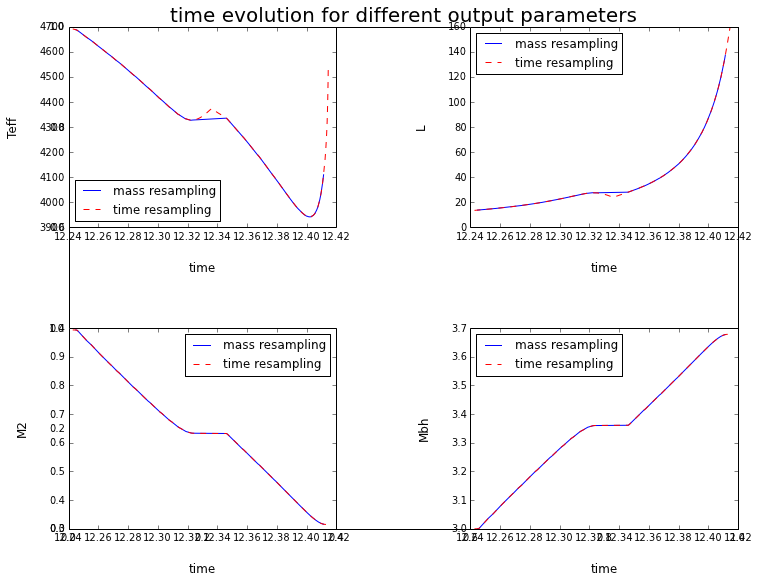

In [15]:
'''Run some time evolution tracks for both resampling'''

### Set up plots ###
fig=plt.figure(figsize = (12,9), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)
plt.title('time evolution for different output parameters', size=20)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axs=[ax1,ax2,ax3,ax4]

#set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['blue'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])

### POSSIBLE OUTPUTS TO PLOT ###
'''
(0'log_dt', 1'he_core_mass', 2'LH', 3'LHe', 4'Teff', 5'L', 
 6'R', 7'logg', 8'center_H1', 9'center_He4', 10'num_retries', 
 11'model', 12'age', 13'P', 14'A', 15'rl_relative_overflow', 16'M2', 
 17'Mbh', 18'log_abs_mdot', 19'xfer_fraction')
 '''
age_index = 12
timesteps = np.linspace(0,999,1000)

### Choose the track number you want to look at ###
track = 150
print 'The initial conditions for track %i are: Mbh = %f, M2 = %f, & P = %f' % (track,inputs[track,0],inputs[track,1],inputs[track,2])
    
### Choose 4 outputs to plot time evolution ###
evo=[4,5,16,17]    

### For labeling, reference a sample path ###
sample_path = '/Users/michaelzevin/Documents/Stellar Evolution/Data/npy_resampled/file1.npz'
sample = np.load(sample_path)


for i in xrange(len(axs)):
    
    # Set up subplot
    ax = axs[i]
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel('time', rotation=0, labelpad=20, size=12)
    ax.set_ylabel(sample['xr1'].dtype.names[evo[i]], rotation=90, labelpad=20, size=12)
    ax.legend([lc1, lc2], ['mass resampling', 'time resampling'], loc=0)
    
    # Pick out interpolation for each correlation and plot
    resample_1=[]
    resample_2=[]
    time_1=[]
    time_2=[]
    for j in xrange(1000):
        resample_1.append(outputs_1[track][j][evo[i]])
        resample_2.append(outputs_2[track][j][evo[i]])
        time_1.append((outputs_1[track][j][age_index])/10**9)
        time_2.append((outputs_2[track][j][age_index])/10**9)
    ax.plot(time_1, resample_1, 'b-')
    ax.plot(time_2, resample_2, 'r--')
    
plt.show()


In [16]:
'''Convert list into matrix of shape (track,parameter,timestep)'''
matrix_1 = np.zeros((len(outputs_1),1000,20))
matrix_2 = np.zeros((len(outputs_2),1000,20))
data_1 = np.array(outputs_1)
data_2 = np.array(outputs_2)

for i in xrange(len(data_1)):
    for j in xrange(1000):
        for k in xrange(20):
            matrix_1[i,j,k]=data_1[i,j][k]
            matrix_2[i,j,k]=data_2[i,j][k]
            
outputs_1 = np.swapaxes(matrix_1,1,2)
outputs_2 = np.swapaxes(matrix_2,1,2)

In [17]:
'''Pick random IC to leave out, interpolate over this and compare with actual'''
random_track_num=randint(0,len(inputs))
temp = list(inputs)
random_IC = array(temp.pop(random_track_num))   # Pop out random track number from inputs
temp = array(temp)

temp_out_1 = list(outputs_1)
temp_out_2 = list(outputs_2)
temp_out_1.pop(random_track_num)
temp_out_2.pop(random_track_num)
temp_out_1 = array(temp_out_1)
temp_out_2 = array(temp_out_2)

print "The randomly-selected track is %i with initial conditions Mbh = %f, M2 = %f, & P = %f" % (random_track_num,random_IC[0],random_IC[1],random_IC[2])


The randomly-selected track is 143 with initial conditions Mbh = 3.000000, M2 = 0.993600, & P = 3.850730


In [18]:
'''Run GP on the remaining dataset'''
'''Define GP function'''

def GP(y):
    gp = gaussian_process.GaussianProcess(corr='absolute_exponential', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,nugget=2e-5)
    ''' other corr: 'absolute_exponential', 'squared_exponential', 'generalized_exponential', 'cubic', 'linear' '''
    x = np.atleast_2d(temp)   # x data in "temp" is the same...just the initial conditions
    y = np.atleast_2d(y).T    # Had to take the transpose when I cut the outputs
    
    gp.fit(x, y)
    
    x_pred = np.atleast_2d(random_IC)   # x_pred is just the initial condition left out
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
        
    return y_pred, sigma


'''Choose the output paramters to run GP over

0: log_dt: timestep in years
1: he_core_mass: the mass of the core of the donor star that contains helium and heavier elements (no hydrogen) in solar masses. During the main sequence he_core_mass=0
2: LH: the total nuclear power generated from H burning (in solar luminosities)
3: LHe: the total nuclear power generated from He burning (in solar luminosities)
4: Teff: the effective temperature of the donor star [K]
5: L: the luminosity of the donor star in solar luminosities
6: R: the radius of the donor star in solar radii
7: logg: the logarithm  of the surface gravity of the star in cm/s^2
8: center_H1: the mass fraction of H1 at the center of the star
9: center_He4: the mass fraction of He4 at the center of the star
10: num_retries: the total number of retries that the solver had to take (not useful for interpolation)
11: model: timestep number
12: age: the age of the star in years
13: P: orbital period (I think in days…)
14: A: orbital separation in solar radii
15: rl_relative_overflow: (R_L-R)/R_L, whe R is the radius of the donor star (M2) and R_L is its roche lobe radius. Negative values mean that the start is not filling its Roche lobe yet.
16: M2: the mass of the donor star in solar masses
17: Mbh: the mass of the accretor in solar radii
18: log_abs_mdot: the logarith of the the absolute value of dM2/dt (mass loss rate of the donor star) in solar masses per year
19: xfer_fraction: the fraction of log_abs_mdot that is being accreted onto the companion. Conservative mass-transfer gives xfer_fraction=1'''

parameters=['log_dt', 'he_core_mass', 'LH', 'LHe', 'Teff', 'L', 
    'R', 'logg', 'center_H1', 'center_He4', 'num_retries', 
    'model', 'age', 'P', 'A', 'rl_relative_overflow', 'M2', 
    'Mbh', 'log_abs_mdot', 'xfer_fraction']

output_params = [4,5,6,12,13,16,18]

### Only use the mass resampling ###
outputs = outputs_1
temp_out = temp_out_1


In [19]:
### Run GP for each timestep, not including the one left out ###
### Run for each of the outputs in "output_params" ###
### Only run for mass resampling (1) ###

outputs_pred=np.zeros((len(output_params),1000))   # Create a matrix for all the output values and errors
outputs_sigma=np.zeros((len(output_params),1000))

num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)

for num in xrange(len(output_params)):
    start_time = time.time()   # Start the clock
    cut_outputs = temp_out[:,output_params[num],:].T   # Choose all the outputs to pool over...
    results = pool.map(GP,cut_outputs)
    
    # Add results to matrix holding output predictions & error
    results = array(results)
    for i in xrange(len(results)):
        outputs_pred[num,i]=results[i,0,0]
        outputs_sigma[num,i]=results[i,1,0]
    
    elapsed = time.time() - start_time   # See how long it took
    print 'Done with the GP for %s...it only took %f seconds!' % (parameters[output_params[num]],elapsed)
    

Done with the GP for Teff...it only took 77.342618 seconds!
Done with the GP for L...it only took 58.455392 seconds!
Done with the GP for R...it only took 48.657680 seconds!
Done with the GP for age...it only took 74.829317 seconds!
Done with the GP for P...it only took 42.930176 seconds!
Done with the GP for M2...it only took 57.657939 seconds!
Done with the GP for log_abs_mdot...it only took 56.181576 seconds!


The choice of outputs are:
0: Teff
1: L
2: R
3: age
4: P
5: M2
6: log_abs_mdot


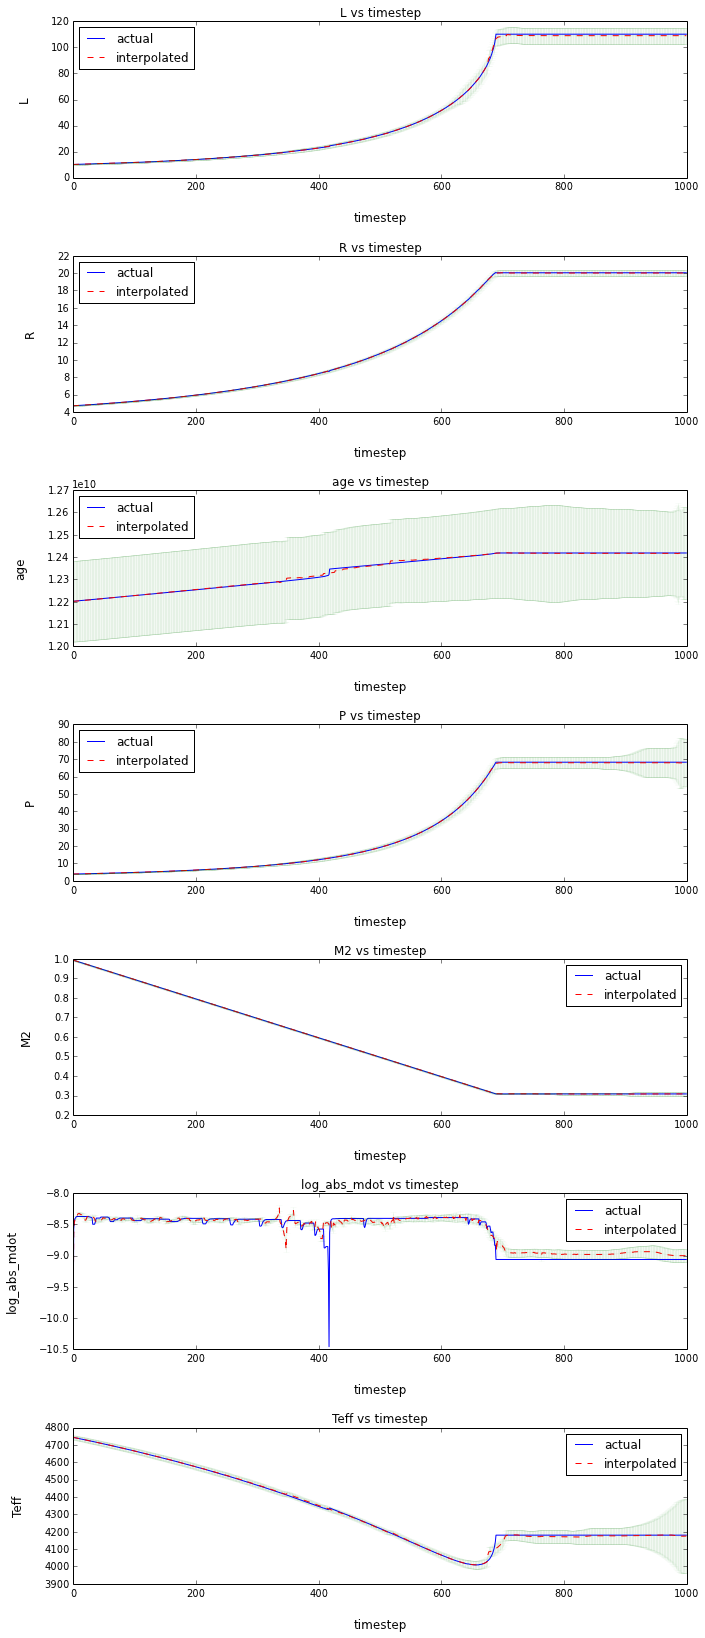

In [21]:
'''Plot evolution tracks for actual and interpolated'''
# First, plot all of the output parameters vs timestep

### Set up plots ###
fig=plt.figure(figsize = (11,4*len(output_params)), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)

#set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['blue'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])

# Choose how many of the timesteps to plot (max 1000)
timesteps = np.linspace(0,999,1000)
start = 0
stop = 1000

# Pull out the actual values to compare with interpolated
actual = np.zeros((len(output_params),1000))
for number in xrange(len(output_params)):
    i=0
    while i < 1000:
        # Pick actual outputs from mass resampling...
        actual[number,i] = outputs[random_track_num,output_params[number],i]
        i+=1
        

# Make a plot for each of the output parameters from the Gaussian Process
for i in xrange(len(output_params)):
    ax = fig.add_subplot(len(output_params),1,i)
    ax.set_xlabel('timestep', rotation=0, labelpad=20, size=12)
    ax.set_ylabel(parameters[output_params[i]], rotation=90, labelpad=20, size=12)
    ax.legend([lc1, lc2], ['actual', 'interpolated'], loc=0)
    ax.set_title(parameters[output_params[i]] + " vs timestep")
    # Plot actual evolution
    ax.plot(timesteps[start:stop], actual[i][start:stop], 'b-')
    # Plot interpolated evolution with error bars
    ax.plot(timesteps[start:stop], outputs_pred[i][start:stop],'r--')
    ax.errorbar(timesteps[start:stop], outputs_pred[i][start:stop], yerr=outputs_sigma[i][start:stop], 
                linestyle='-', color='g', alpha=.05)
    
print "The choice of outputs are:"
for i in xrange(len(outputs_pred)):
    print "%i: %s" % (i,parameters[output_params[i]])

<Container object of 3 artists>

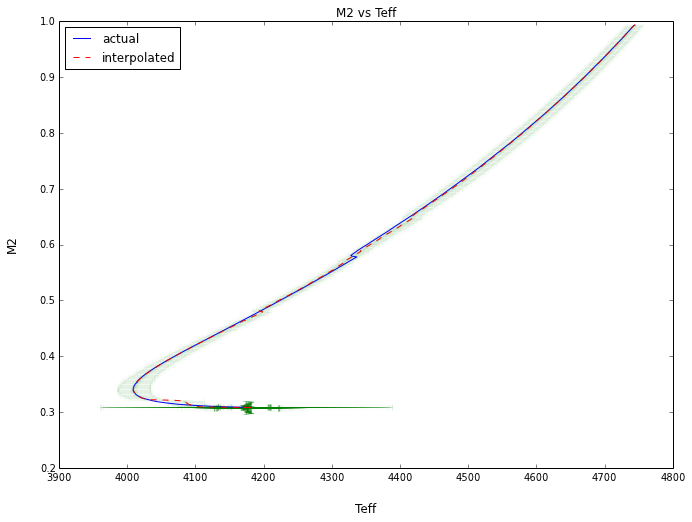

In [25]:
# Next, plot two outputs against each other and compare to actual

### Set up plots ###
fig=plt.figure(figsize = (11,8), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)

output_choice = [0,5] # Change this to change what is plot. Options are printed above. 

ax = fig.add_subplot(1,1,1)
ax.set_xlabel(parameters[output_params[output_choice[0]]], rotation=0, labelpad=20, size=12)
ax.set_ylabel(parameters[output_params[output_choice[1]]], rotation=90, labelpad=20, size=12)
ax.legend([lc1, lc2], ['actual', 'interpolated'], loc=0)
ax.set_title(parameters[output_params[output_choice[1]]] + " vs " + parameters[output_params[output_choice[0]]])
# Plot actual evolution
ax.plot(actual[output_choice[0]][start:stop], actual[output_choice[1]][start:stop], 'b-')
# Plot interpolated evolution with error bars
ax.plot(outputs_pred[output_choice[0]][start:stop], 
        outputs_pred[output_choice[1]][start:stop],'r--')
ax.errorbar(outputs_pred[output_choice[0]][start:stop], 
            outputs_pred[output_choice[1]][start:stop], 
            xerr=outputs_sigma[output_choice[0]][start:stop],
            yerr=outputs_sigma[output_choice[1]][start:stop],
            linestyle='-', color='g', alpha=.05)

In [ ]:
### Systematically leave-one-out, calculate chi-squared for each...
### Get code running on Quest
### Hear from Tassos about initial conditions => sort initial conditions in a systematic way
### Linear interpolation